# Small Instance

## Solving the optimization model

### Requirements

In [1]:
from pyomo.environ import *
import time
import numpy as np
import matplotlib.pyplot as plt

### Parameters

In [60]:
# --- Global parameters

N = 2
N_max = 5
tw = 50
M = 1000

# --- Costs

c_pm = 10  # 10
c_cm = 25   # 25
c_op = 2    # 2
c_transport = 50    # 50

# --- Maintenance parameters

R = 1
k = 1
W = [[1,0]]
Tr = [[0,0]]
# Operation time parameters

H = 30
h = 5
H0_J0 = [0, 0, 10, 20, 23]
H0_J1 = [12, 20, 34]
H_J = [H0_J0,H0_J1]

### Solving function

In [30]:
def solv_wf(N,tw,M,c_pm,c_cm,c_op,c_transport,R,k,H,h,H_J,W,Tr):

    # --- 1. Model creation

    model = ConcreteModel()
    # Sets
    model.I = RangeSet(0,N-1)          # wind farms
    model.IJ = Set(initialize=[(i, j) for i in range(N) for j in range(len(H_J[i]))], dimen=2)
    model.T = RangeSet(0,tw-1)          # time steps
    model.O = RangeSet(0,R-1)           # maintenance crews
        
    # Params
    model.c_pm = Param(initialize=c_pm)
    model.c_cm = Param(initialize=c_cm)
    model.c_op = Param(initialize=c_op)
    model.c_transport = Param(initialize=c_transport)
    model.H = Param(initialize=H)
    model.h_ = Param(initialize=h)
    model.k = Param(initialize=k)
    model.M = Param(initialize=M)

    # Variables
    
    model.h = Var(model.T, model.IJ, within=NonNegativeIntegers)
    model.pm = Var(model.T, model.IJ, within=Binary)
    model.cm = Var(model.T, model.IJ, within=Binary)
    model.f = Var(model.T, model.IJ, within=Binary)
    model.w = Var(model.T, model.O, model.I, within=Binary)
    model.tr = Var(model.T, model.O, model.I, within=Binary)

    # We fix the initial values of the operating time
    for (i, j) in model.IJ:
        model.h[0, i, j].fix(H_J[i][j])
    
    # We fix the initial locations of the different maintenance teams
    
    for o in model.O : 
        for i in model.I :
            model.w[0,o,i].fix(W[o][i])
            model.tr[0,o,i].fix(Tr[o][i])
    
    # Objective function
    
    def total_cost(model):
        maintenance_costs = sum(
            model.c_pm * model.pm[t, i, j] +
            model.c_cm * model.cm[t, i, j] +
            model.c_op * model.f[t, i, j]
            for t in model.T for (i, j) in model.IJ
        )
        transport_costs = sum(
            model.c_transport * model.tr[t, o, i]
            for t in model.T for o in model.O for i in model.I
        )
        return maintenance_costs + transport_costs

    model.obj = Objective(rule=total_cost, sense=minimize)
    # Constraints

    ## 1 Capacity constraint (≤ k interventions per farm per step)
    def capacity_rule(model, t, i):
        turbines_i = [j for (i2, j) in model.IJ if i2 == i]
        return sum(model.pm[t, i, j] + model.cm[t, i, j] for j in turbines_i) <= \
            model.k * sum(model.w[t, o, i] for o in model.O)
    model.capacity = Constraint(model.T, model.I, rule=capacity_rule)

    ## 2 One state per turbine
    def one_state_rule(model, t, i, j):
        return model.pm[t, i, j] + model.cm[t, i, j] + model.f[t, i, j] <= 1
    model.one_state = Constraint(model.T, model.IJ, rule=one_state_rule)

    ## 3 Preventive maintenance window - Rewriten with more linear formats
    def pm_window_low(model, t, i, j):
        return model.h[t, i, j] >= (model.H - model.h_) * model.pm[t, i, j]
    def pm_window_high(model, t, i, j):
        return model.h[t, i, j] <= (model.H - 1) + model.M * (1 - model.pm[t, i, j])
    model.pm_window_low = Constraint(model.T, model.IJ, rule=pm_window_low)
    model.pm_window_high = Constraint(model.T, model.IJ, rule=pm_window_high)

    ## 4 Failure condition (if h ≥ H)
    def failure_lower_bound(model, t, i, j):
        # f_{t,i,j} + cm_{t,i,j} ≥ M⁻¹ (h_{t,i,j} - H + 1)
        return model.f[t, i, j] + model.cm[t,i,j]>= (model.h[t, i, j] - model.H + 1) / model.M

    def failure_upper_bound(model, t, i, j):
        # f_{t,i,j} + cm_{t,i,j} ≤ 1 + M⁻¹ (h_{t,i,j} - H)
        return model.f[t, i, j] + model.cm[t,i,j]<= 1 + (model.h[t, i, j] - model.H) / model.M

    model.failure_lower = Constraint(model.T, model.IJ, rule=failure_lower_bound)
    model.failure_upper = Constraint(model.T, model.IJ, rule=failure_upper_bound)

    ## 5. Corrective maintenance only if h ≥ H
    def cm_failure_rule(model, t, i, j):
        # cm_{t,i,j} ≤ 1 + M⁻¹ (h_{t,i,j} - H)
        return model.cm[t, i, j] <= 1 + (model.h[t, i, j] - model.H) / model.M

    model.cm_failure = Constraint(model.T, model.IJ, rule=cm_failure_rule)

    ## 6 Evolution of operating time h
    def h_evolution_upper(model, t, i, j):
        if t == 0:
            return Constraint.Skip
        return model.h[t, i, j] <= model.h[t-1, i, j] + 1 + model.M * (model.pm[t-1, i, j] + model.cm[t-1, i, j])
    def h_evolution_lower(model, t, i, j):
        if t == 0:
            return Constraint.Skip
        return model.h[t, i, j] >= model.h[t-1, i, j] + 1 - model.M * (model.pm[t-1, i, j] + model.cm[t-1, i, j])
    def h_reset(model, t, i, j):
        if t == 0:
            return Constraint.Skip
        return model.h[t, i, j] <= model.M * (1 - (model.pm[t-1, i, j] + model.cm[t-1, i, j]))
    model.h_evolution_upper = Constraint(model.T, model.IJ, rule=h_evolution_upper)
    model.h_evolution_lower = Constraint(model.T, model.IJ, rule=h_evolution_lower)
    model.h_reset = Constraint(model.T, model.IJ, rule=h_reset)

    ## 7 Crew presence or travel continuity
    def crew_continuity(model, t, o, i):
        if t == 0:
            return Constraint.Skip
        return model.w[t, o, i] <= model.w[t-1, o, i] + model.tr[t-1, o, i]
    model.crew_continuity = Constraint(model.T, model.O, model.I, rule=crew_continuity)
    
    ## 8 A crew is always at one place at a time
    def crew_location(model, t, o, i):
        return sum((model.w[t, o, i] + model.tr[t,o,i]) for i in model.I) == 1
    model.crew_location = Constraint(model.T, model.O, model.I, rule=crew_location)
        
    # --- 7. Solve
    
    # Nombre de variables
    num_var = len(list(model.component_data_objects(ctype=pyomo.environ.Var)))
    print("Nombre de variables :", num_var)

    # Nombre de paramètres
    num_param = len(list(model.component_data_objects(ctype=pyomo.environ.Param)))
    print("Nombre de paramètres :", num_param)

    # Nombre de contraintes
    num_constraint = len(list(model.component_data_objects(ctype=pyomo.environ.Constraint)))
    print("Nombre de contraintes :", num_constraint)
    
    start = time.time() 
    solver = SolverFactory("gurobi")  # or 'gurobi' if licensed
    results = solver.solve(model, tee=True)
    end = time.time()
    comp = end-start
    
    # -- 8. Transform it into computable forms
    
    max_turbines = max(len(H_J[i]) for i in range(N))

    def var_to_array(var, t_dim, i_dim, j_dim):
        arr = np.zeros((t_dim, i_dim, j_dim))
        for (t, i, j) in var:
            arr[t, i, j] = value(var[t, i, j])
        return arr

    n_j = max_turbines
    ar_h = var_to_array(model.h, tw, N, n_j)
    ar_pm = var_to_array(model.pm, tw, N, n_j)
    ar_cm = var_to_array(model.cm, tw, N, n_j)
    ar_f = var_to_array(model.f, tw, N, n_j)

    # w, tr ont une dimension en plus (O)
    ar_w = np.zeros((tw, R, N))
    ar_tr = np.zeros((tw, R, N))
    for (t, o, i) in model.w:
        ar_w[t, o, i] = value(model.w[t, o, i])
    for (t, o, i) in model.tr:
        ar_tr[t, o, i] = value(model.tr[t, o, i])
        
    return value(model.obj),ar_h,ar_pm,ar_cm,ar_f,ar_w,ar_tr,comp,num_var,num_param,num_constraint
    

In [61]:
obj,h_r,pm,cm,f,w,tr,comp,var,param,constraint = solv_wf(N,tw,M,c_pm,c_cm,c_op,c_transport,R,k,H,h,H_J,W,Tr)

Nombre de variables : 1800
Nombre de paramètres : 8
Nombre de contraintes : 3874
Read LP format model from file /var/folders/z7/f69nzsvj3ng6l90wkyzwbxbm0000gn/T/tmpnotj_x4p.pyomo.lp
Reading time = 0.02 seconds
x1: 3874 rows, 1789 columns, 11836 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 21.6.0 21H1123)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3874 rows, 1789 columns and 11836 nonzeros
Model fingerprint: 0x83494528
Variable types: 1 continuous, 1788 integer (1396 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [2e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 1e+03]
Presolve removed 1798 rows and 654 columns
Presolve time: 0.16s
Presolved: 2076 rows, 1135 columns, 6119 nonzeros
Variable types: 0 continuous, 1135 integer (850 binary)
Found heuristic solution: objective 1700.0000000

## Visualisation of results

### Visualisation of operation time

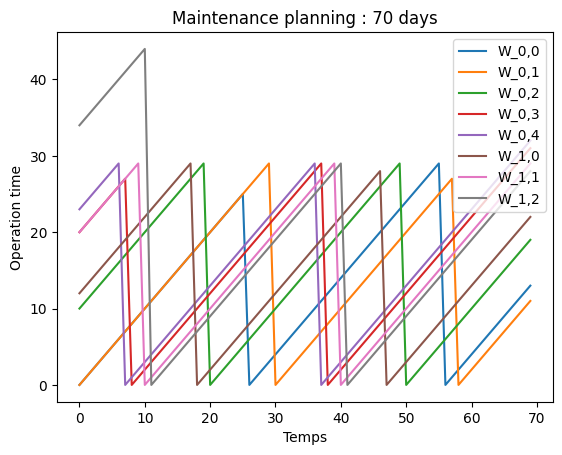

In [ ]:
IJ =[(i, j) for i in range(N) for j in range(len(H_J[i]))]
T = np.arange(0,tw)

for (i,j) in IJ :
    H_ij = h_r[:,i,j]
    plt.plot(T,H_ij,label = f"W_{i},{j}")
    
plt.legend()
plt.xlabel("Temps")
plt.ylabel("Operation time")
plt.title(f"Maintenance planning : {tw} days")
plt.show()

### Maintenance planning

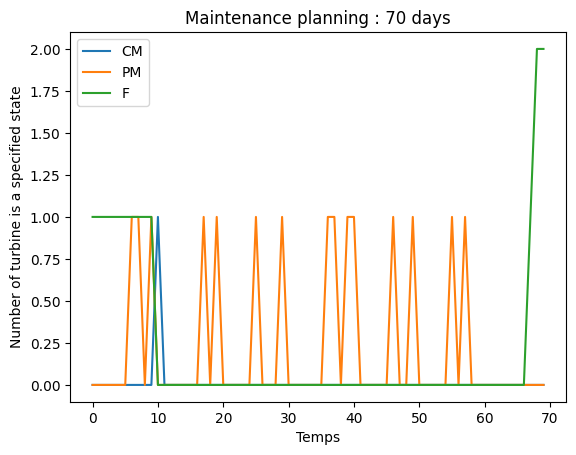

In [ ]:
CM = cm.sum(axis = (1,2))
PM = pm.sum(axis = (1,2))
F = f.sum(axis = (1,2))

plt.plot(T,CM,label = "CM")
plt.plot(T,PM,label = "PM")
plt.plot(T,F,label = "F")

plt.legend()
plt.xlabel("Temps")
plt.ylabel("Number of turbine is a specified state")
plt.title(f"Maintenance planning : {tw} days")
plt.show()

['In transport', 'Wind farm 1', 'Wind farm 2']


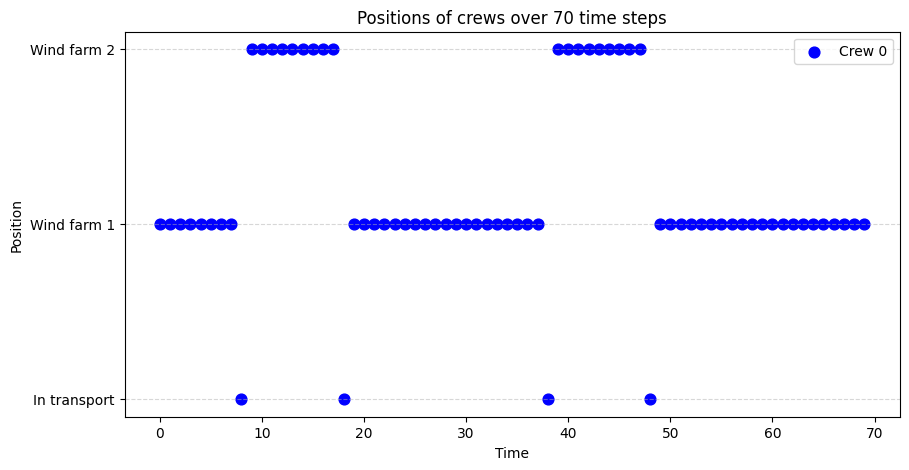

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

T = np.arange(0, tw)

def position(w):
    # transforme la position du crew en un numéro unique
    pos = 0 
    for i in range(N):
        pos += (i+1)*w[i]
    return pos

# Préparer les positions pour chaque crew
W_pos = np.zeros((tw, R))

for i in range(tw):
    for j in range(R):        
        W_pos[i, j] = position(w[i, j])

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 5))

# points discrets pour chaque crew

colors =["blue","red","green","yellow","purple","orange"]

for j in range(R):
    ax.scatter(T, W_pos[:, j], label=f"Crew {j}", s=60, color=colors[j])

# axe Y customisé
print(["In transport"] + [f"Wind farm {i}" for i in range(1,N+1)])
ax.set_yticks([i for i in range(N+1)])
ax.set_yticklabels(["In transport"] + [f"Wind farm {i}" for i in range(1,N+1)])

ax.set_xlabel("Time")
ax.set_ylabel("Position")
ax.set_title(f"Positions of crews over {tw} time steps")
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import matplotlib.lines as mlines

def visualize_maintenance_schedule_with_images(ar_h, ar_pm, ar_cm, ar_f, ar_w, tw, N, 
                                                img_turbine="eolienne.png"):
    alpha = 0.5
    """
    Visualisation animée du planning de maintenance :
    - chaque éolienne est représentée par une image,
    - le fond est une image (ex. mer),
    - couleurs de halo selon l'état de la turbine,
    - affichage de h sous chaque turbine.
    """

    # --- Figure et axes ---
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.set_xlim(-1, 8)
    ax.set_ylim(-2, 3)
    ax.axis("off")

    # --- Image d’éolienne ---
    try:
        turbine_img = mpimg.imread(img_turbine)
        turbine_icon = OffsetImage(turbine_img, zoom=0.15)
    except FileNotFoundError:
        raise FileNotFoundError(f"Image '{img_turbine}' introuvable dans le répertoire courant.")

    # --- Coordonnées des turbines ---
    turbines_top = [(i, 2) for i in range(5)]     # parc 0
    turbines_bottom = [(i, 0) for i in range(3)]  # parc 1
    crew_pos_x = 6.5

    # --- Création des images d’éoliennes ---
    turbine_icons_top = [AnnotationBbox(turbine_icon, (x, y), frameon=True, pad=0.4, bboxprops=dict(edgecolor = 'none',alpha=alpha))
                         for x, y in turbines_top]
    turbine_icons_bottom = [AnnotationBbox(turbine_icon, (x, y), frameon=True, pad=0.4, bboxprops=dict(edgecolor = 'none', alpha=alpha))
                            for x, y in turbines_bottom]

    for icon in turbine_icons_top + turbine_icons_bottom:
        ax.add_artist(icon)

    # --- Texte du h sous chaque éolienne ---
    h_texts_top = [
        ax.text(x, 1.4, "", ha="center", va="top", fontsize=9, color="black", zorder=3)
        for x, _ in turbines_top
    ]
    h_texts_bottom = [
        ax.text(x, -0.6, "", ha="center", va="top", fontsize=9, color="black", zorder=3)
        for x, _ in turbines_bottom
    ]

    # --- Crew point ---
    crew_point, = ax.plot([crew_pos_x], [1], "o", color="blue", markersize=15, zorder=3)

    # --- Titres --- 
    ax.text(0.5, 2.8, "Maintenance Planning", fontsize=14, fontweight="bold", zorder=3)
    ax.text(-2, 2, "Wind farm 1", fontsize=10, fontweight="bold", zorder=3)
    ax.text(-2, 0, "Wind farm 2", fontsize=10, fontweight="bold", zorder=3)
    ax.text(5.6, 2.8, "Crew position", fontsize=14, fontweight = "bold", zorder=3)
    legend_elements = [
    mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Failure'),
    mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=10, label='Corrective'),
    mlines.Line2D([], [], color='gold', marker='o', linestyle='None', markersize=10, label='Preventive'),
    mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=10, label='Normal')
    ]
    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4, frameon=False)

    timestep_text = ax.text(2.5, -1.5, "", fontsize=12, zorder=3)

    # --- Fonction update ---
    def update(t):
        # --- Parc 0 ---
        for j in range(5):
            if ar_f[t, 0, j] == 1:
                color = "red"
            elif ar_cm[t, 0, j] == 1:
                color = "orange"
            elif ar_pm[t, 0, j] == 1:
                color = "yellow"
            else:
                color = "green"

            turbine_icons_top[j].patch.set_facecolor(color)
            turbine_icons_top[j].patch.set_alpha(alpha)
            h_texts_top[j].set_text(f"{ar_h[t,0,j]:.0f}")

        # --- Parc 1 ---
        for j in range(3):
            if ar_f[t, 1, j] == 1:
                color = "red"
            elif ar_cm[t, 1, j] == 1:
                color = "orange"
            elif ar_pm[t, 1, j] == 1:
                color = "yellow"
            else:
                color = "green"

            turbine_icons_bottom[j].patch.set_facecolor(color)
            turbine_icons_bottom[j].patch.set_alpha(alpha)
            h_texts_bottom[j].set_text(f"{ar_h[t,1,j]:.0f}")

        # --- Crew position ---
        if ar_w[t, 0, 0] == 1:
            crew_point.set_data([crew_pos_x], [2])
        elif ar_w[t, 0, 1] == 1:
            crew_point.set_data([crew_pos_x], [0])
        else:
            crew_point.set_data([crew_pos_x], [1])

        timestep_text.set_text(f"Time step: {t}/{tw-1}")

        return turbine_icons_top + turbine_icons_bottom + [crew_point, timestep_text]

    ani = FuncAnimation(fig, update, frames=range(tw), interval=600, blit=False, repeat=True)

    plt.show()
    return ani


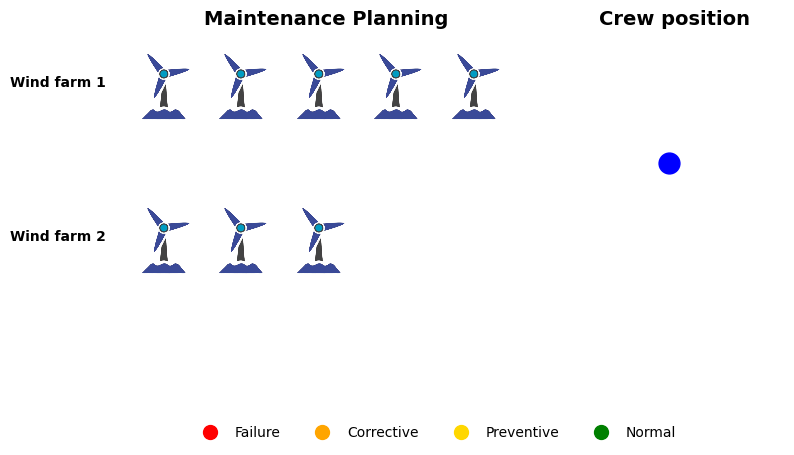

In [ ]:

ani = visualize_maintenance_schedule_with_images(h_r, pm, cm, f, w, tw, N)

from IPython.display import HTML
HTML(ani.to_jshtml())

## Sensitivity Analysis

### How much does improving the time window improve the solution ?

In [5]:
C = []
OBJ = []
param_list = []
variable_list = []
Constr = []
C_ratio = []
for temp_tw in range(15,71,2):
    print(temp_tw)
    obj,h_r,pm,cm,f,w,tr,comp,var,par,constraint = solv_wf(N,temp_tw,M,c_pm,c_cm,c_op,c_transport,R,k,H,h,H_J,W,Tr)
    C.append(comp)
    OBJ.append(obj)
    param_list.append(par)
    variable_list.append(var)
    Constr.append(constraint)
    C_ratio.append(comp/sqrt(var*constraint))

15
Nombre de variables : 540
Nombre de paramètres : 8
Nombre de contraintes : 1144
Read LP format model from file /var/folders/z7/f69nzsvj3ng6l90wkyzwbxbm0000gn/T/tmpcg7xpbvu.pyomo.lp
Reading time = 0.02 seconds
x1: 1144 rows, 529 columns, 3436 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 21.6.0 21H1123)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1144 rows, 529 columns and 3436 nonzeros
Model fingerprint: 0x77f6b28e
Variable types: 1 continuous, 528 integer (416 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [2e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 1e+03]
Presolve removed 907 rows and 384 columns
Presolve time: 0.10s
Presolved: 237 rows, 145 columns, 653 nonzeros
Variable types: 0 continuous, 145 integer (110 binary)
Found heuristic solution: objective 416.0000000
Found heu

### Visualisation of computation time

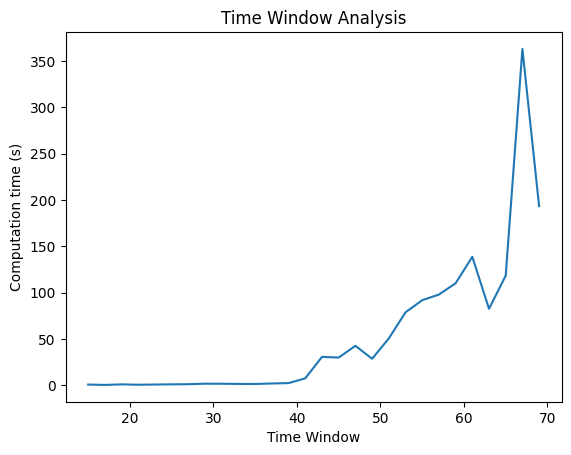

In [17]:
T = np.arange(15,71,2)
C_ar = np.array(C)
plt.plot(T,C_ar)
plt.xlabel("Time Window")
plt.ylabel("Computation time (s)")
plt.title("Time Window Analysis")
plt.show()

0.9264017079517128


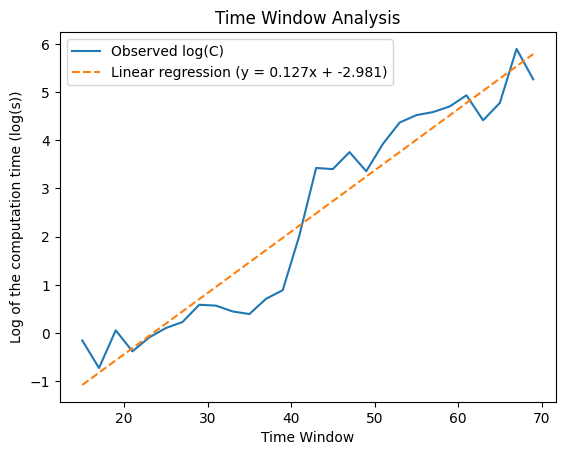

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Exemple : tes données
log_C = np.log(C_ar)
# Calcul de la régression linéaire : C_ar ≈ a*T + b
coeffs = np.polyfit(T, np.log(C_ar), 1)  # régression sur le log si tu veux une échelle log
a, b = coeffs

# Valeurs prédites (la droite)
Regr = a*T + b

# R² calculation
ss_res = np.sum((log_C - Regr) ** 2)
ss_tot = np.sum((log_C - np.mean(log_C)) ** 2)
r2 = 1 - (ss_res / ss_tot)
print(r2)

# Tracé
plt.plot(T, log_C, label="Observed log(C)")
plt.plot(T, Regr, '--', label=f"Linear regression (y = {a:.3f}x + {b:.3f})")

plt.xlabel("Time Window")
plt.ylabel("Log of the computation time (log(s))")
plt.title("Time Window Analysis")
plt.legend()
plt.show()


### Cost ratio

In [45]:
Transp_obj = []
Transp_cm = []
Transp_pm = []
Transp_f = []
Op_obj = []
Op_cm = []
Op_pm = []
Op_f = []
for i in range(2,102,2):
    obj,h_r,pm,cm,f,w,tr,comp,var,param,constraint = solv_wf(N,30,M,c_pm,c_cm,c_op,i,R,k,H,h,H_J,W,Tr)
    Transp_obj.append(obj)
    Transp_cm.append(int(cm.sum(axis=(0,1,2))))
    Transp_pm.append(int(pm.sum(axis=(0,1,2))))
    Transp_f.append(int(f.sum(axis=(0,1,2))))
    obj,h_r,pm,cm,f,w,tr,comp,var,param,constraint = solv_wf(N,30,M,c_pm,c_cm,i,c_transport,R,k,H,h,H_J,W,Tr)
    Op_obj.append(obj)
    Op_cm.append(int(cm.sum(axis=(0,1,2))))
    Op_pm.append(int(pm.sum(axis=(0,1,2))))
    Op_f.append(int(f.sum(axis=(0,1,2))))

Nombre de variables : 1080
Nombre de paramètres : 8
Nombre de contraintes : 2314
Read LP format model from file /var/folders/z7/f69nzsvj3ng6l90wkyzwbxbm0000gn/T/tmpgv7_vtx1.pyomo.lp
Reading time = 0.02 seconds
x1: 2314 rows, 1069 columns, 7036 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 21.6.0 21H1123)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2314 rows, 1069 columns and 7036 nonzeros
Model fingerprint: 0xad94dd48
Variable types: 1 continuous, 1068 integer (836 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 1e+03]
Presolve removed 1484 rows and 594 columns
Presolve time: 0.11s
Presolved: 830 rows, 475 columns, 2321 nonzeros
Variable types: 0 continuous, 475 integer (350 binary)
Found heuristic solution: objective 280.0000000
Found 

Text(0, 0.5, 'Optimisation cost')

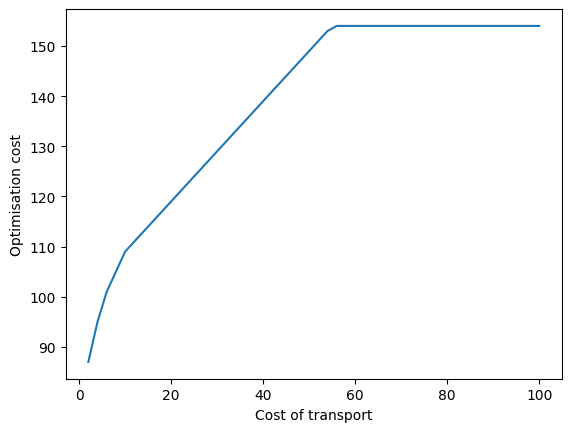

In [51]:
T = np.arange(2,102,2)
Tr_obj = np.array(Transp_obj)
plt.plot(T,Tr_obj)
plt.xlabel("Cost of transport")
plt.ylabel("Optimisation cost")


[ 8  8 10 13 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65 65
 65 65]


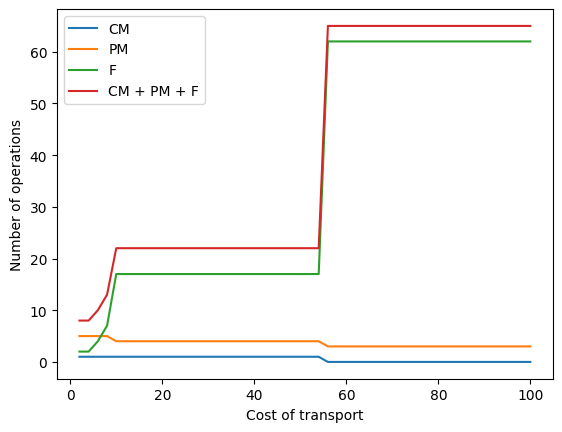

In [ ]:
T = np.arange(2,102,2)
Tr_cm = np.array(Transp_cm)
Tr_pm = np.array(Transp_pm)
Tr_f = np.array(Transp_f)
Tr_op = Tr_cm + Tr_pm + Tr_f
plt.plot(T,Tr_cm,label = "CM")
plt.plot(T,Tr_pm,label = "PM")
plt.plot(T,Tr_f,label = "F")
plt.plot(T,Tr_op,label = "CM + PM + F")
plt.xlabel("Cost of transport")
plt.ylabel("Number of operations")
plt.legend()

print(Tr_op)

Text(0, 0.5, 'Optimisation cost')

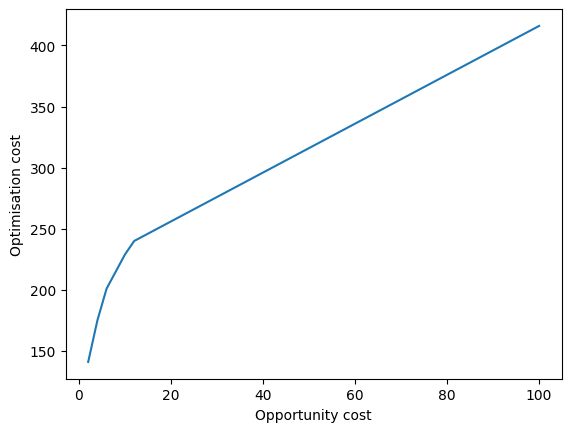

In [52]:
Op_obj_ar = np.array(Op_obj)
plt.plot(T,Op_obj_ar)
plt.xlabel("Opportunity cost")
plt.ylabel("Optimisation cost")


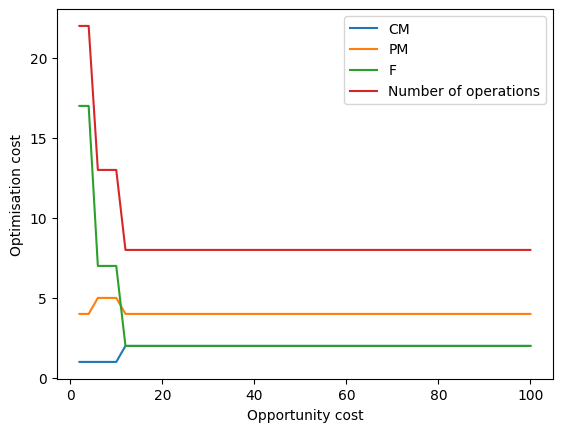

In [53]:
Op_cm_ar =  np.array(Op_cm)
Op_pm_ar = np.array(Op_pm)
Op_f_ar = np.array(Op_f)
Op_op_ar = Op_cm_ar + Op_pm_ar + Op_f_ar
plt.plot(T,Op_cm_ar,label = "CM")
plt.plot(T,Op_pm_ar,label = "PM")
plt.plot(T,Op_f_ar,label = "F")
plt.plot(T,Op_op_ar,label = "Number of operations")
plt.xlabel("Opportunity cost")
plt.ylabel("Optimisation cost")
plt.legend()

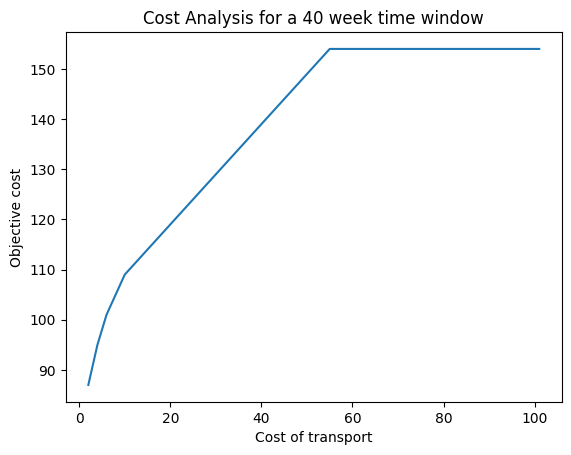

In [ ]:
C_transport = np.arange(2,102)

plt.plot(C_transport,np.array(OBJ))
plt.xlabel("Cost of transport")
plt.ylabel("Objective cost")
plt.title("Cost Analysis for a 40 week time window")
plt.show()


## Extension of the time window

In [58]:
# --- Initial fixed parameters

N = 2
N_max = 5
tw_used = 30
M = 1000
c_pm = 10  # 10
c_cm = 25   # 25
c_op = 2    # 2
c_transport = 50    # 50
R = 1
k = 1

H = 30
h = 5


In [59]:
# Initial varying parameters

W_temp = [[1,0]]
Tr_temp = [[0,0]]
H0_J0_temp = [0, 0, 10, 20, 23]
n0 = 5
H0_J1_temp = [12, 20, 34]
n1 = 3
H_J_temp = [H0_J0_temp,H0_J1_temp]

IJ =[(i, j) for i in range(N) for j in range(len(H_J_temp[i]))]

# We insert the full time window that we want to display

Global_tw = 100
Effective_tw = 10

# Implementing the model 

Nb_opt_pb = Global_tw//Effective_tw + 1
Last_crop = Global_tw - (Nb_opt_pb-1)*Effective_tw
global_opt = 0 
global_comp = 0 

def solver_effect(Effective_tw,h_r,pm,cm,f,tr,w):
    opt = 0
    for t in range(Effective_tw):
        for (i,j) in IJ:
            opt += c_pm*pm[t,i,j] + c_cm*cm[t,i,j] + c_op*f[t,i,j]
        for i in range(N):
            for o in range(R):
                opt += c_transport*tr[t,o,i]
    return opt,h_r[0:Effective_tw],cm[0:Effective_tw],pm[0:Effective_tw],f[0:Effective_tw],tr[0:Effective_tw],w[0:Effective_tw]

for i in range(Nb_opt_pb):
    obj,h_r,pm,cm,f,w,tr,comp,var,param,constraint = solv_wf(N,tw_used,M,c_pm,c_cm,c_op,c_transport,R,k,H,h,H_J_temp,W_temp,Tr_temp)
    print(i*Effective_tw)
    
    # updating the varying parameters
    
    W_temp = w[-1].tolist()
    Tr_temp = tr[-1].tolist()
    H0_J0_temp = h_r[Effective_tw][0][0:n0].tolist()
    H1_J1_temp = h_r[Effective_tw][1][0:n1].tolist()
    H_J_temp = [H0_J0_temp,H1_J1_temp]
    
    # Keeping in mind the previous results
    if i < Nb_opt_pb - 1: 
        opt_add,hr_add,cm_add,pm_add,f_add,tr_add,w_add = solver_effect(Effective_tw,h_r,pm,cm,f,tr,w)
        global_opt += opt_add
        global_comp += comp
        if i == 0:
            Global_hr = hr_add
            Global_cm = cm_add
            Global_pm = pm_add
            Global_f = f_add
            Global_tr = tr_add
            Global_w = w_add
        else:
            Global_hr = np.concatenate((Global_hr,hr_add))
            Global_cm = np.concatenate((Global_cm,cm_add))
            Global_pm = np.concatenate((Global_pm,pm_add))
            Global_f = np.concatenate((Global_f,f_add))
            Global_tr = np.concatenate((Global_tr,tr_add))
            Global_w = np.concatenate((Global_w,w_add))
    else:
        opt_add,hr_add,cm_add,pm_add,f_add,tr_add,w_add = solver_effect(Last_crop,h_r,pm,cm,f,tr,w)
        global_opt += opt_add
        global_comp += comp
        Global_hr = np.concatenate((Global_hr,hr_add))
        Global_cm = np.concatenate((Global_cm,cm_add))
        Global_pm = np.concatenate((Global_pm,pm_add))
        Global_f = np.concatenate((Global_f,f_add))
        Global_tr = np.concatenate((Global_tr,tr_add))
        Global_w = np.concatenate((Global_w,w_add))

Nombre de variables : 1080
Nombre de paramètres : 8
Nombre de contraintes : 2314
Read LP format model from file /var/folders/z7/f69nzsvj3ng6l90wkyzwbxbm0000gn/T/tmp3d453bcr.pyomo.lp
Reading time = 0.02 seconds
x1: 2314 rows, 1069 columns, 7036 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 21.6.0 21H1123)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 2314 rows, 1069 columns and 7036 nonzeros
Model fingerprint: 0xffe02489
Variable types: 1 continuous, 1068 integer (836 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  Objective range  [2e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 1e+03]
Presolve removed 1484 rows and 594 columns
Presolve time: 0.16s
Presolved: 830 rows, 475 columns, 2321 nonzeros
Variable types: 0 continuous, 475 integer (350 binary)
Found heuristic solution: objective 930.0000000
Found 

### Visualisation comparative

['In transport', 'Wind farm 1', 'Wind farm 2']


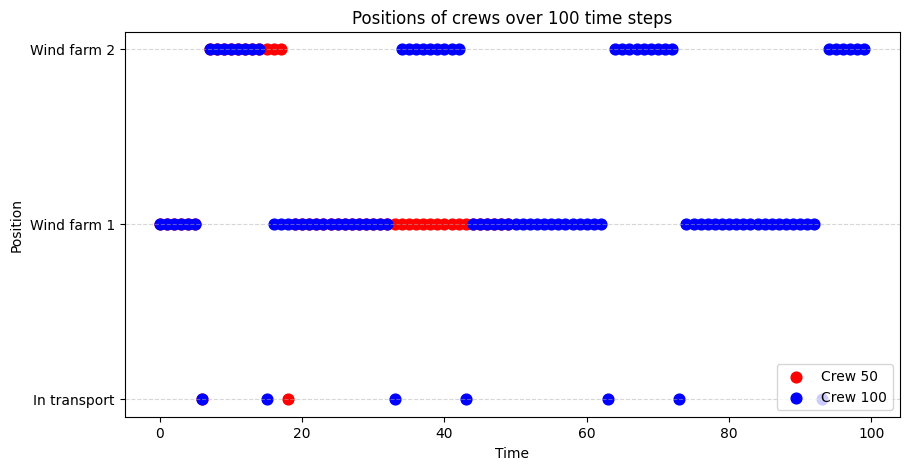

In [62]:
import numpy as np
import matplotlib.pyplot as plt

T = np.arange(0, Global_tw)

# Préparer les positions pour chaque crew
W_pos2 = np.zeros((Global_tw, R))

for i in range(tw):
    for j in range(R):        
        W_pos2[i, j] = position(w[i, j])

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 5))

# points discrets pour chaque crew

colors =["blue","red","green","yellow","purple","orange"]

for j in range(R):
    ax.scatter(T[:tw], W_pos2[:tw, j], label=f"Crew 50", s=60, color='red')

def position(w):
    # transforme la position du crew en un numéro unique
    pos = 0 
    for i in range(N):
        pos += (i+1)*w[i]
    return pos

# Préparer les positions pour chaque crew
W_pos = np.zeros((Global_tw, R))

for t in range(Global_tw):
    for o in range(R):        
        W_pos[t, o] = position(Global_w[t, o])

# points discrets pour chaque crew

colors =["blue","red","green","yellow","purple","orange"]

for j in range(R):
    ax.scatter(T, W_pos[:, j], label=f"Crew 100", s=60, color=colors[j])

# axe Y customisé
print(["In transport"] + [f"Wind farm {i}" for i in range(1,N+1)])
ax.set_yticks([i for i in range(N+1)])
ax.set_yticklabels(["In transport"] + [f"Wind farm {i}" for i in range(1,N+1)])

ax.set_xlabel("Time")
ax.set_ylabel("Position")
ax.set_title(f"Positions of crews over {Global_tw} time steps")
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [63]:
print(global_comp)

10.7220139503479
